In [2]:
library(data.table)
library(Rmisc)
library(ggplot2)
library(dplyr)
library(reshape2)
library(bit)
library(zoo)

## Data Preperation

### 1. Read raw data (i.e., reviews)

In [3]:
rws=fread("../data/rws.all.csv")

### 2. Read facial attributes for both hosts and guests and merge those attributes with the review data

In [4]:
guest=fread("../data/guest.attribute.csv")
colnames(guest)[c(8)]=c("g.ethnicity")
guest=guest[,c("guest_id","g.ethnicity")]
rws.gh=left_join(rws,guest, by="guest_id",type='left')

In [5]:
#-Note that h.num_face==0 represents hots without any human face in their profile photos.
#-In this case, h.ethnicity is empty string.
#-Additional filtering is required depending on analysis,
#-since profile photos with more than 1 human face also have empty string in the h.ethnicity column.
host=fread("../data/host.attribute.csv")
colnames(host)[c(5,8)]=c("h.num_face","h.ethnicity")
host=host[,c("listing_id","host_id","h.num_face","h.ethnicity")]
rws.gh=left_join(rws.gh,host, by=c("listing_id","host_id"))

In [6]:
tmp_host=host
tmp_host$h.ethnicity=ifelse(tmp_host$h.num_face==0, "RA", tmp_host$h.ethnicity)

table(unique(tmp_host[,c("listing_id", "host_id", "h.ethnicity")])$h.ethnicity)


      ASIAN BLACK    RA WHITE 
 4217  4717  4621  6112 12731 

In [7]:
#-Remove those racially unidentified guests
rws.gh=rws.gh[rws.gh$g.ethnicity!="",]

In [8]:
#-Label RA for racially ambiguous hosts
rws.gh$h.ethnicity=ifelse(rws.gh$h.num_face==0, "RA", rws.gh$h.ethnicity)

In [9]:
#-Remove those racially unidentified hosts (with multiple human faces in their profile photos)
rws.gh=rws.gh[rws.gh$h.ethnicity!="",]

### 3. Create booking- / staying-level reputation and endorsement signals

#### 3.1. Create columns for # of previous reviews and race of previous reviewers for each booking/staying

In [10]:
df=rws.gh

In [11]:
df=df %>% group_by(listing_id) %>% arrange(date) %>%
  mutate(cum.cnt=row_number()-1,
         rws.race=lag(g.ethnicity, n = 1, default = NA))

#### 3.2. Count the previous guest race for each booking

In [12]:
#-Create column and add counter
df$g.W.cnt=ifelse(df$rws.race=="WHITE", 1, 0)
df$g.B.cnt=ifelse(df$rws.race=="BLACK", 1, 0)
df$g.A.cnt=ifelse(df$rws.race=="ASIAN", 1, 0)

In [13]:
#-Sort reviews for each listing by date
#-Then roll sum racial compositions in the most recent 6 reviews for each booking
#-Note that the most 6 reviews are the proxy of front-page reviews
df = df %>% group_by(listing_id) %>% arrange(date) %>%
    mutate(top6.W=rollsumr(g.W.cnt==1, 6, fill=NA),
           top6.B=rollsumr(g.B.cnt==1, 6, fill=NA),
           top6.A=rollsumr(g.A.cnt==1, 6, fill=NA))

In [14]:
#-Code the first review's the most recent previous reviewer's race as 0
#-and then count all the previous reviewers' races cumulatively
df$rws.race[which(is.na(df$rws.race))]=0

df = df %>% group_by(listing_id) %>% arrange(date) %>% 
    mutate(g.W.cnt=cumsum(rws.race=="WHITE"),
           g.B.cnt=cumsum(rws.race=="BLACK"),
           g.A.cnt=cumsum(rws.race=="ASIAN"))

In [15]:
df=as.data.table(df)

In [16]:
#-Extract only listings that allow instant booking
df=df[which(df$instant_bookable=="t"),]

In [17]:
length(unique(df$listing_id))

[1] 9861

In [18]:
table(unique(rws.gh[,c("listing_id", "host_id", "h.ethnicity")])$h.ethnicity)


ASIAN BLACK    RA WHITE 
 4284  4266  5642 11654 

# ----------------------------------------------------------------------------------------

## In-group racial preference on host selection

- Fig. 1
- Pairing probability across all possible racial group pairs

### 1. Compute paring probabilities across different race combinations

#### 1.1. Extract only relevant columns and create counterfactuals

In [19]:
create_ctf_1 = function(df.x) {
    df.tmp.ctf=df.x
    df.tmp.ctf$pairing.status=0
    df.tmp.ctf$g.ethnicity=ifelse(df.tmp.ctf$g.ethnicity=="BLACK" |
                                  df.tmp.ctf$g.ethnicity=="ASIAN",
                                  "WHITE", "BLACK")
    return(df.tmp.ctf)
}

create_ctf_2 = function(df.x) {
    df.tmp.ctf=df.x
    df.tmp.ctf$pairing.status=0
    df.tmp.ctf$g.ethnicity=ifelse(df.tmp.ctf$g.ethnicity=="BLACK" |
                                  df.tmp.ctf$g.ethnicity=="WHITE",
                                  "ASIAN", "BLACK")
    return(df.tmp.ctf)
}

create_ctf = function(df.x) {
    return(rbind(create_ctf_1(df.x),create_ctf_2(df.x)))
}

In [20]:
df.tmp.obs=df[, c("h.ethnicity", "g.ethnicity"), with=FALSE]
df.tmp.obs$pairing.status=1

In [21]:
df.tmp.ctf=create_ctf(df.tmp.obs)

#### 1.2. Combine counterfactuals with observations and compute average pairing probabilities 

In [22]:
df.obs.ctf=rbind(df.tmp.obs,df.tmp.ctf)

In [23]:
summary.pairing.prob.obs=summarySE(df.obs.ctf, measurevar="pairing.status",
                                   groupvars=c("h.ethnicity", "g.ethnicity"))

### 2. Compute the pairing probabilities compared to the random baseline and plot the results

#### 2.1. Create n random baselines (for standard errors) and compute the difference with the observations

In [24]:
df.tmp.rnd=df.tmp.obs

In [25]:
#-Permutate g.ethnicity for n times to create a random baseline
#-to compare the difference between obeservations and random chances
#-as well as to create standard errors... .

start_time=Sys.time()

shuffle_time=1000
l_rand=list()
l_diff=list()
for(x in 1:shuffle_time){
    df.tmp=df.tmp.rnd
    df.tmp$g.ethnicity=df.tmp.rnd[sample(nrow(df.tmp.rnd), replace=FALSE),]$g.ethnicity
        
    df.tmp.ctf=create_ctf(df.tmp)
    df.tmp.rnd.ctf=rbind(df.tmp,df.tmp.ctf)
    
    df.tmp.pairing.prob.obs=summarySE(df.tmp.rnd.ctf, measurevar="pairing.status",
                                      groupvars=c("h.ethnicity", "g.ethnicity"))
    l_rand[[paste("g.rnd.ethnicity", x, sep=".")]]=df.tmp.pairing.prob.obs
    df.tmp.diff=df.tmp.pairing.prob.obs[,1:2]
    df.tmp.diff$prob.diff=summary.pairing.prob.obs$pairing.status - df.tmp.pairing.prob.obs$pairing.status
    l_diff[[paste("obs.rnd.diff", x, sep=".")]]=df.tmp.diff
}

end_time=Sys.time()
end_time - start_time

Time difference of 5.332191 mins

In [26]:
df.pairing.prob.diff=do.call(rbind.data.frame, l_diff)

In [ ]:
#-Save
saveRDS(summary.pairing.prob.obs, "../data/fig_1_summary.pairing.prob.obs.RDS")
saveRDS(df.pairing.prob.diff, "../data/fig_1_pairing.prob.diff.RDS")

In [ ]:
#-Read
summary.pairing.prob.obs=readRDS("../data/fig_1_summary.pairing.prob.obs.RDS")
df.pairing.prob.diff=readRDS("../data/fig_1_pairing.prob.diff.RDS")

#### 2.2. Compute the mean (and CI) of the probability difference

In [27]:
summary.pairing.prob.diff=summarySE(df.pairing.prob.diff, measurevar="prob.diff",
                                    groupvars=c("h.ethnicity", "g.ethnicity"))

In [28]:
summary.pairing.prob.diff$ci=summary.pairing.prob.diff$sd*1.96

#### 2.3. Plot the results

In [29]:
summary.pairing.prob.diff$h.ethnicity=ifelse(summary.pairing.prob.diff$h.ethnicity=="RA",
                                             "Racially\nUnidentified", summary.pairing.prob.diff$h.ethnicity)

In [30]:
re_from="\\b([[:alpha:]])([[:alpha:]]+)"
summary.pairing.prob.diff$h.ethnicity=gsub(re_from, "\\U\\1\\L\\2", summary.pairing.prob.diff$h.ethnicity, perl=TRUE)

In [31]:
summary.pairing.prob.diff$h.ethnicity=factor(summary.pairing.prob.diff$h.ethnicity,
                                             levels=c("Racially\nUnidentified","White","Asian","Black"),
                                             ordered=TRUE)

In [32]:
summary.pairing.prob.diff$g.ethnicity=factor(summary.pairing.prob.diff$g.ethnicity,
                                             levels=c("WHITE","ASIAN","BLACK"),
                                             ordered=TRUE)

In [33]:
summary.pairing.prob.diff

h.ethnicity,g.ethnicity,N,prob.diff,sd,se,ci
<ord>,<ord>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Asian,ASIAN,1000,0.030422504,0.0022499777,7.115054e-05,0.004409956
Asian,BLACK,1000,-0.014477806,0.0019637279,6.209853e-05,0.003848907
Asian,WHITE,1000,-0.015944697,0.0025945061,8.204549e-05,0.005085232
Black,ASIAN,1000,-0.005940223,0.0020226090,6.396051e-05,0.003964314
Black,BLACK,1000,0.052389903,0.0018213345,5.759565e-05,0.003569816
Black,WHITE,1000,-0.046449680,0.0023855298,7.543708e-05,0.004675638
Racially Unidentified,ASIAN,1000,-0.003357484,0.0017590463,5.562593e-05,0.003447731
Racially Unidentified,BLACK,1000,0.006934492,0.0015804559,4.997840e-05,0.003097693
Racially Unidentified,WHITE,1000,-0.003577008,0.0019930933,6.302715e-05,0.003906463


In [34]:
l_guest.race.label=c(
    "BLACK"="Black Guest",
    "WHITE"="White Guest",
    "ASIAN"="Asian Guest")

dodge=position_dodge(width=0.5)
pdf("../output/fig_1.pdf", width=7.5, height=5)
g = ggplot(summary.pairing.prob.diff, aes(x=h.ethnicity, y=prob.diff)) + 
  xlab("Host Race") + 
  ylab("Pairing Probability Compared to Random") +
  geom_point(position=dodge, size=2.5) +
  geom_errorbar(aes(ymin=prob.diff-ci, ymax=prob.diff+ci),
                size=0.75, width=0.15, position=dodge) +
  scale_y_continuous(limits=c(-0.06,0.06), expand=c(0,0), breaks=seq(-0.06,0.06,0.03),
                     labels=seq(-0.06,0.06,0.03)) +
  facet_grid(~g.ethnicity, margins=FALSE, switch="y",
             labeller=as_labeller(l_guest.race.label)) + theme_classic() +
  theme(panel.border=element_rect(fill=NA, size=0.3),
        panel.grid.major=element_blank(),
        axis.text.x=element_text(angle=45, hjust=1)) +
  geom_hline(yintercept=0, linetype="dashed", color="#D55E00") +
  scale_color_grey(start=0.5, end=0.5) + theme(text=element_text(size=15))
plot(g)
dev.off()

pdf 
  2

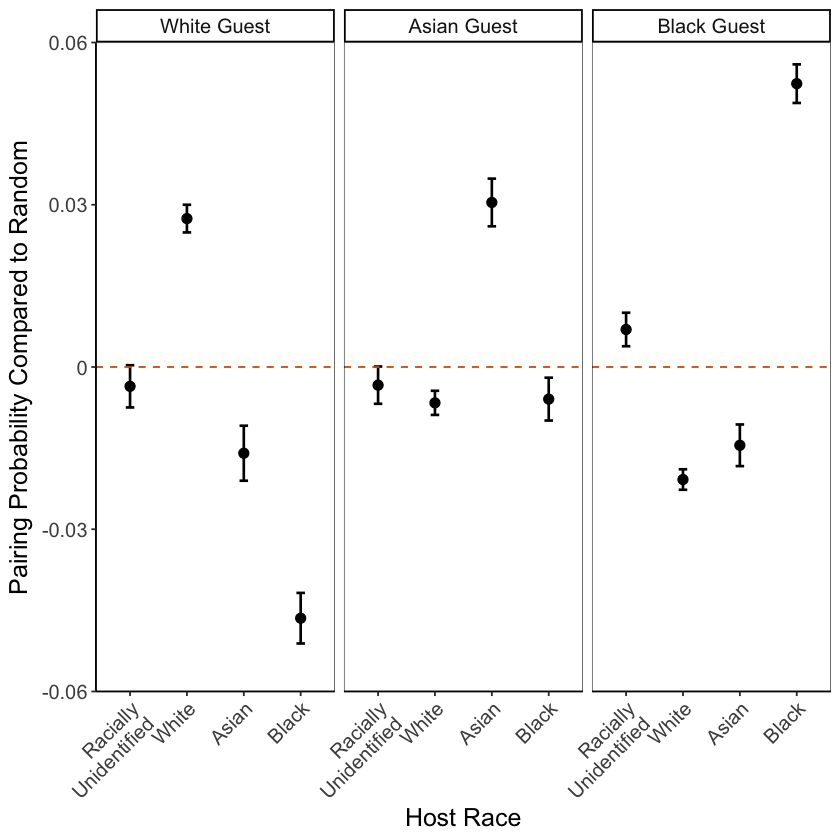

In [35]:
g

# ----------------------------------------------------------------------------------------

# The same analysis with another approach

- Throughout all the analyses reported in the paper, we used above method to compute the normed probabilities. Using this approach, we could check more details of the distributional information for each shuffling iteration.
- However, there are other simpler ways to do the same job. The below is an example, which is much faster and easier to implement!
- We confirm that the results are identical, obviously.

In [36]:
df.tmp.obs=df[, c("h.ethnicity", "g.ethnicity"), with=FALSE]

In [37]:
t_obs=table(df.tmp.obs)
t_obs_prob=t(apply(t_obs, 1, function(x) x/sum(x)))
t_obs_prob=as.data.frame(as.table(t_obs_prob))
t_obs_prob

h.ethnicity,g.ethnicity,Freq
<fct>,<fct>,<dbl>
ASIAN,ASIAN,0.2694236
BLACK,ASIAN,0.2327399
RA,ASIAN,0.2353811
WHITE,ASIAN,0.2320276
ASIAN,BLACK,0.1495185
BLACK,BLACK,0.2165508
RA,BLACK,0.1709928
WHITE,BLACK,0.1433045
ASIAN,WHITE,0.5810579


In [38]:
df.tmp=df.tmp.obs
df.tmp$g.ethnicity=df.tmp[sample(nrow(df.tmp), replace=FALSE),]$g.ethnicity
t_rnd=table(df.tmp)
t_rnd_prob=t(apply(t_rnd, 1, function(x) x/sum(x)))
t_rnd_prob=as.data.frame(as.table(t_rnd_prob))
t_rnd_prob

h.ethnicity,g.ethnicity,Freq
<fct>,<fct>,<dbl>
ASIAN,ASIAN,0.2366113
BLACK,ASIAN,0.2346036
RA,ASIAN,0.2410920
WHITE,ASIAN,0.2400114
ASIAN,BLACK,0.1639955
BLACK,BLACK,0.1657302
RA,BLACK,0.1656178
WHITE,BLACK,0.1626174
ASIAN,WHITE,0.5993932


In [39]:
t_obs=table(df.tmp.obs)
t_obs_prob=t(apply(t_obs, 1, function(x) x/sum(x)))
t_obs_prob=as.data.frame(as.table(t_obs_prob))
summary.pairing.prob.obs=t_obs_prob

df.tmp.rnd=df.tmp.obs

#-Permutate g.ethnicity for n times to create a random baseline
#-to compare the difference between obeservations and random chances
#-as well as to create standard errors... .

start_time=Sys.time()

shuffle_time=1000
l_diff=list()
for(x in 1:shuffle_time){
    df.tmp=df.tmp.rnd
    df.tmp$g.ethnicity=df.tmp.rnd[sample(nrow(df.tmp.rnd), replace=FALSE),]$g.ethnicity
    t_rnd=table(df.tmp)
    t_rnd_prob=t(apply(t_rnd, 1, function(x) x/sum(x)))
    t_rnd_prob=as.data.frame(as.table(t_rnd_prob))
    df.tmp.pairing.prob.obs=t_rnd_prob
                       
    df.tmp.diff=df.tmp.pairing.prob.obs[,1:2]
    df.tmp.diff$prob.diff=summary.pairing.prob.obs$Freq - df.tmp.pairing.prob.obs$Freq
    l_diff[[paste("obs.rnd.diff", x, sep=".")]]=df.tmp.diff
}

df.pairing.prob.diff=do.call(rbind.data.frame, l_diff)

end_time=Sys.time()
end_time - start_time

Time difference of 44.78364 secs

In [40]:
summary.pairing.prob.diff=summarySE(df.pairing.prob.diff, measurevar="prob.diff",
                                    groupvars=c("h.ethnicity", "g.ethnicity"))

summary.pairing.prob.diff$ci=summary.pairing.prob.diff$sd*1.96

re_from="\\b([[:alpha:]])([[:alpha:]]+)"
summary.pairing.prob.diff$h.ethnicity=gsub(re_from, "\\U\\1\\L\\2", summary.pairing.prob.diff$h.ethnicity, perl=TRUE)

summary.pairing.prob.diff$h.ethnicity=ifelse(summary.pairing.prob.diff$h.ethnicity=="Ra",
                                             "Racially\nUnidentified", summary.pairing.prob.diff$h.ethnicity)

summary.pairing.prob.diff$h.ethnicity=factor(summary.pairing.prob.diff$h.ethnicity,
                                             levels=c("Racially\nUnidentified","White","Asian","Black"),
                                             ordered=TRUE)

summary.pairing.prob.diff$g.ethnicity=factor(summary.pairing.prob.diff$g.ethnicity,
                                             levels=c("WHITE","ASIAN","BLACK"),
                                             ordered=TRUE)

In [43]:
l_guest.race.label=c(
    "BLACK"="Black Guest",
    "WHITE"="White Guest",
    "ASIAN"="Asian Guest")

dodge=position_dodge(width=0.5)
g = ggplot(summary.pairing.prob.diff, aes(x=h.ethnicity, y=prob.diff)) + 
  xlab("Host Race") + 
  ylab("Pairing Probability Compared to Random") +
  geom_point(position=dodge, size=2.5) +
  geom_errorbar(aes(ymin=prob.diff-ci, ymax=prob.diff+ci),
                size=0.75, width=0.15, position=dodge) +
  facet_grid(~g.ethnicity, margins=FALSE, switch="y",
             labeller=as_labeller(l_guest.race.label)) + theme_classic() +
  scale_y_continuous(limits=c(-0.06,0.06), breaks=seq(-0.06,0.06,0.02),
                     labels=c(seq(-0.06,0.06,0.02))) +
  theme(panel.border=element_rect(fill=NA, size=0.3),
        panel.grid.major=element_blank(),
        axis.text.x=element_text(angle=90, hjust=1, vjust=0.4)) +
  geom_hline(yintercept=0, linetype="dashed", color="#D55E00") +
  scale_color_grey(start=0.5, end=0.5) + theme(text=element_text(size=15))

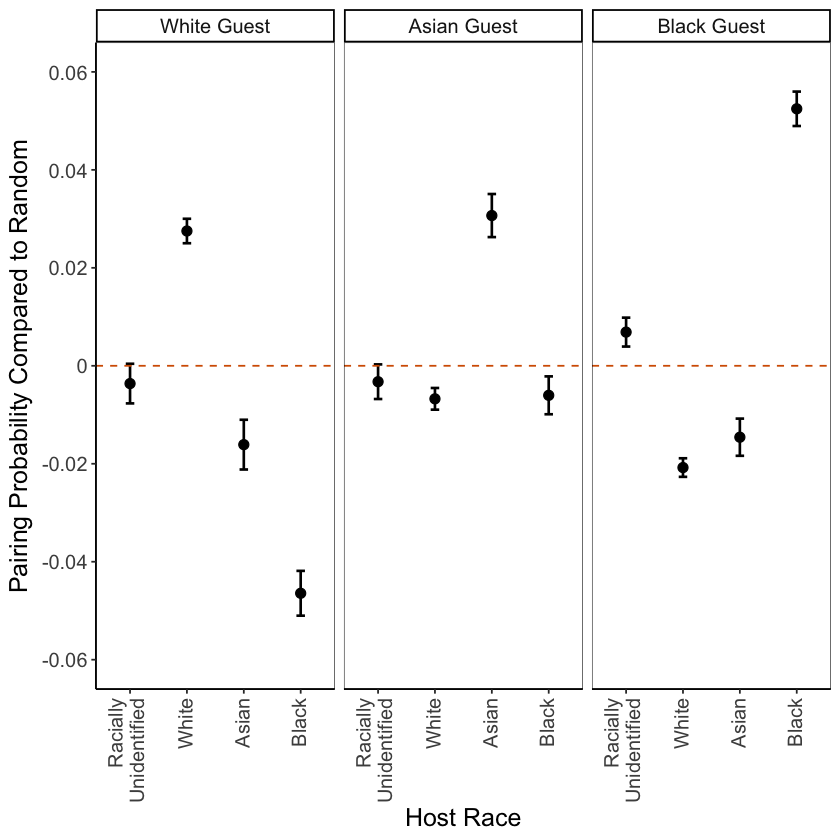

In [44]:
g